In [1]:
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.cityscapes import CityscapesCustom
from models.deeplabv2.deeplabv2 import get_deeplab_v2
import torch.optim as optim

In [2]:
#Set device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import requests
from zipfile import ZipFile
from io import BytesIO

# Define the path to the dataset
dataset_path = 'https://drive.usercontent.google.com/download?id=1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2&export=download&authuser=0&confirm=t&uuid=631b9184-6338-41d0-8446-57809d0d36a1&at=APZUnTVko8hTKhN-ulNwRGMsAa2a%3A1714747554229'

# Send a GET request to the URL
response = requests.get(dataset_path)
# Check if the request was successful
if response.status_code == 200:
    # Open the downloaded bytes and extract them
    with ZipFile(BytesIO(response.content)) as zip_file:
        zip_file.extractall(os.path.dirname(os.getcwd()))
    print('Download and extraction complete!')

In [3]:
#Create Dataloaders for Cityscapes
cityscapes_dir = os.path.dirname(os.getcwd()) + '/Cityscapes/Cityscapes/Cityspaces/'

train_dataset = CityscapesCustom(cityscapes_dir, 'train')
test_dataset = CityscapesCustom(cityscapes_dir, 'val')

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f'Train: {len(train_dataset)} images, divided into {len(train_dataloader)} batches of size {train_dataloader.batch_size}')
print(f'Test: {len(test_dataset)} images, divided into {len(test_dataloader)} batches of size {test_dataloader.batch_size}')

Train: 1572 images, divided into 786 batches of size 2
Test: 500 images, divided into 250 batches of size 2


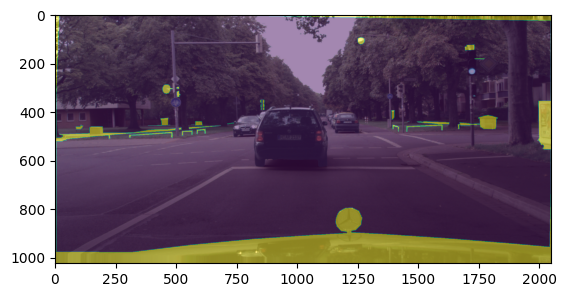

Number of labels in the image: 13


In [4]:
import matplotlib.pyplot as plt

def show_image_label(image, label):
    if image.shape[0] == 1:  # If grayscale, squeeze to remove the channel dimension
        image = np.squeeze(image, axis=0)
    else:  # If RGB, transpose to move the color dimension to the end
        image = np.transpose(image, (1, 2, 0))
        
    if label.shape[0] == 1:  # If grayscale, squeeze to remove the channel dimension
        label = np.squeeze(label, axis=0)
        
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
    plt.imshow(label, alpha=0.5)
    plt.show()

    print(f'Number of labels in the image: {len(np.unique(label))}')

image, label = train_dataset[0]
show_image_label(np.array(image), np.array(label))

In [3]:
#Set up the model with the pretrained weights
model = get_deeplab_v2().to(device)

Deeplab pretraining loading...


In [6]:
#Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [7]:
#Define the training loop

def train(model, train_loader, test_loader, epochs, lr, device):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for image, label in train_loader:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for image, label in test_loader:
                image, label = image.to(device), label.to(device)
                output = model(image)
                loss = criterion(output, label)
                test_loss += loss.item()
            test_loss /= len(test_loader)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

In [8]:
#Train the model for 10 epochs with a learning rate of 0.001
train(model, train_dataloader, test_dataloader, 10, 0.001, device)

KeyboardInterrupt: 